In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import community

import community as community_louvain

from community_visualization import assign_colors_to_communities, draw_graph_with_communities



c:\Users\Dell 5520\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df_original = pd.read_csv('data/primaryschool.csv', header=None, delimiter='\t', names = ['time', 'u', 'v', 'grade_u', 'grade_v'])
print(df_original.head())

metadata = pd.read_csv('data/metadata.txt', header=None, delimiter='\t', names = ['id', 'grade', 'gender'])
print(metadata.head())

    time     u     v grade_u grade_v
0  31220  1558  1567      3B      3B
1  31220  1560  1570      3B      3B
2  31220  1567  1574      3B      3B
3  31220  1632  1818      4B      4B
4  31220  1632  1866      4B      4B
     id grade gender
0  1426    5B      M
1  1427    5B      F
2  1428    5B      M
3  1429    5B      F
4  1430    5B      M


In [3]:
# Sort dataframe by source, target, and timestamp
df_original = df_original.sort_values(by=['u', 'v', 'time'])

# Initialize an empty list to store the results
df = []

# Iterate through the dataframe to calculate weights
for (u, v), group in df_original.groupby(['u', 'v']):
    timestamps = group['time'].tolist()
    weight = 1
    first_time = timestamps[0]
    for i in range(1, len(timestamps)):
        if timestamps[i] == timestamps[i-1] + 20:
            weight += 1
        else:
            df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})
            weight = 1
            first_time = timestamps[i]
    df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})

# Create a new dataframe from the result
df = pd.DataFrame(df)

print(df.head(10))

      u     v  weight   time
0  1426  1427       1  36740
1  1426  1427       2  36940
2  1426  1427       2  39640
3  1426  1427       2  52820
4  1426  1427       1  54760
5  1426  1427       2  56580
6  1426  1427       1  60680
7  1426  1427       2  61080
8  1426  1427       1  61160
9  1426  1427       2  61320


In [4]:
grade_dict = {"1A": "red", "1B": "red", "2A": "orange", "2B": "orange", "3A": "gray", "3B": "gray", "4A": "cyan", "4B": "cyan", "5A": "blue", "5B": "blue", "Teachers": "black"}
grade_dict_more = {"1A": "firebrick", "1B": "red", "2A": "orange", "2B": "sandybrown", "3A": "slategray", "3B": "gray", "4A": "darkturquoise", "4B": "cyan", "5A": "cornflowerblue", "5B": "blue", "Teachers": "black"}

node_grade = {}
node_gender = {}
for _, row in metadata.iterrows():
    node_grade[row['id']] = row['grade']
    node_gender[row['id']] = row['gender']

gender_dict = {"M": "blue", "F": "magenta", "Unknown": "gray"}

In [5]:
G = nx.Graph()
for _, row in metadata.iterrows():
    if row['grade'] != "Teachers":
        G.add_node(row['id'], color=grade_dict_more[row['grade']])

for _, edge in df.iterrows():
    if node_grade[edge['u']] != "Teachers" and node_grade[edge['v']] != "Teachers":
        G.add_edge(edge['u'], edge['v'], weight=edge['weight'], time=edge['time'])


In [6]:
group = {grade: metadata[metadata['grade'] == grade]['id'].tolist() for grade in metadata['grade'].unique()}
group = {'1A': group['1A'], '1B': group['1B'], '5A': group['5A'], '5B': group['5B']}

In [7]:
d1_min = 31220
d1_max = 62300

d2_min = 117240
d2_max = 148120

In [8]:
first_break = {"1A": "10:40:00", "1B": "10:10:00", "5A": "09:45:00", "5B": "09:45:00"}
first_break_day2 = {"1A": "10:25:00", "1B": "10:05:00", "5A": "10:05:00", "5B": "10:40:00"}


# Task 5


## Louvian weighted

In [13]:
def get_cosine_similarity(df):
    # Make the dataframe symmetric
    df = pd.concat([df, df.rename(columns={'u': 'v', 'v': 'u'})])
    nodes = set(df['u'].unique())
    cosine_similarities = []
    for node in nodes:
        neighbors = set(df[df['u'] == node]['v'])
        
        for neighbor in neighbors:
            neighbors_neighbor = set(df[df['u'] == neighbor]['v'])
            intersection = neighbors.intersection(neighbors_neighbor) # this is the V set
            
            intersection_weights = np.sum([df[(df['u'] == node) & (df['v'] == i)]['weight'].sum() * df[(df['u'] == neighbor) & (df['v'] == i)]['weight'].sum() for i in intersection])
            total_weights = np.sqrt(np.sum([df[(df['u'] == node) & (df['v'] == i)]['weight'].sum()**2 for i in neighbors]) * np.sum([df[(df['u'] == neighbor) & (df['v'] == i)]['weight'].sum()**2 for i in neighbors_neighbor]))
            
            cosine_similarity = intersection_weights / total_weights
            cosine_similarities.append({'u': node, 'v': neighbor, 'weight': cosine_similarity})
            
    return pd.DataFrame(cosine_similarities)

In [18]:
use_cosine_similarity = False

Modularity for 1A is 0.23167032087137956
Modularity for 1B is 0.18781854799682068
Modularity for 5A is 0.25549113829182646
Modularity for 5B is 0.17852591197379095


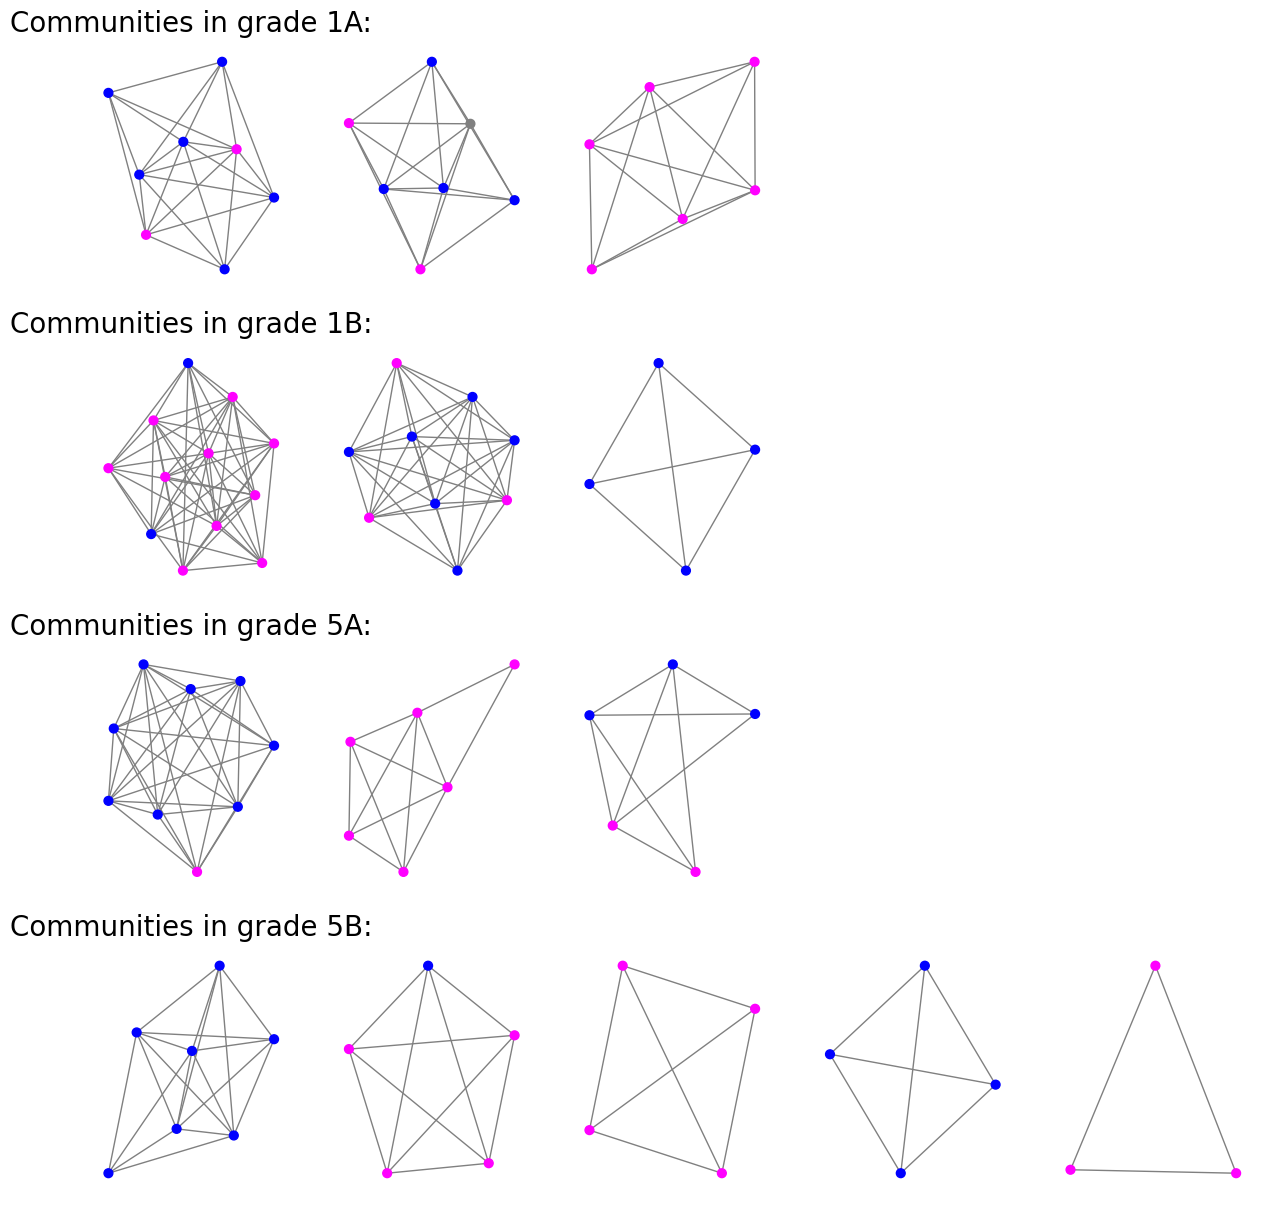

In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain

def time_to_timestamp(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

communities = {}
modularities = {}

for grade, nodes in group.items():
    tmin = time_to_timestamp(first_break[grade])
    tmax = tmin + 30*60 # 10 minutes
   
    # define the graph
    myG = nx.Graph()
    
    # df_filtered = df[(df['u'].isin(nodes)) & (df['v'].isin(nodes)) & (df['time'] >= tmin) & (df['time'] <= tmax)]
    # # add the total time for each edge
    # df_filtered = df_filtered.groupby(['u', 'v']).agg({'weight': 'sum'}).reset_index()

    # count the number of occurrences for each edge
    df_filtered = df_original[(df_original['u'].isin(nodes)) & (df_original['v'].isin(nodes)) & (df_original['time'] >= tmin) & (df_original['time'] <= tmax)]

    df_filtered = df_filtered.groupby(['u', 'v']).size().reset_index(name='weight')

    if use_cosine_similarity:
        df_filtered = get_cosine_similarity(df_filtered)


    for _, edge in df_filtered.iterrows():
        myG.add_edge(edge['u'], edge['v'], weight=edge['weight'])

    # find partition
    partition = community_louvain.best_partition(myG, weight = 'weight')
    # Convert partition dictionary to list of sets
    partition_sets = [set() for _ in range(max(partition.values()) + 1)]
    for node, community_id in partition.items():
        partition_sets[community_id].add(node)
    
    modularity2 = community.modularity(myG, partition_sets, weight='weight')
    print(f"Modularity for {grade} is {modularity2}")
    modularities[grade] = modularity2
    
    # # Draw the graph
    # pos = nx.spring_layout(myG)
    # cmap = plt.get_cmap('viridis')
    # nx.draw_networkx_nodes(myG, pos, partition.keys(), node_size=40, 
    #                     cmap=cmap, node_color=list(partition.values()))
    # nx.draw_networkx_edges(myG, pos, alpha=0.5)
    # plt.title(f" {grade} Louvain Community Detection")
    # plt.show()

    # Create a dictionary to hold subgraphs
    subgraphs = {}
    for community_id in set(partition.values()):
        subgraphs[community_id] = nx.Graph()

    # Add nodes and edges to the corresponding subgraphs
    for node, community_id in partition.items():
        subgraphs[community_id].add_node(node)
        for neighbor in myG.neighbors(node):
            if partition[neighbor] == community_id:
                subgraphs[community_id].add_edge(node, neighbor)

    communities[grade] = subgraphs
    # # Plot each subgraph in a subplot
    # num_communities = len(subgraphs)
    # fig, axes = plt.subplots(1, num_communities, figsize=(5*num_communities, 5))
fig, axes = plt.subplots(4, max([len(c) for c in communities.values()]), figsize=(15, 15))

for i, (grade, subgraphs) in enumerate(communities.items()):
    # Plot each subgraph in a subplot
    # sort subgraphs in order of decreasing number of nodes
    subgraphs = dict(sorted(subgraphs.items(), key=lambda x: -len(x[1].nodes())))
    for j, (community_id, subgraph) in enumerate(subgraphs.items()):
        pos = nx.spring_layout(subgraph)
        node_colors = [gender_dict[node_gender[node]] for node in subgraph.nodes()]
        #node_colors = [grade_dict_more[node_grade[node]] for node in subgraph.nodes()]
        nx.draw(subgraph, pos, ax=axes[i][j], with_labels=False, node_size=40, node_color=node_colors, edge_color='gray')
    
    #in the remaing axes in the row, plot nothing
    for j in range(len(subgraphs), len(axes[i])):
        axes[i][j].axis('off')
    axes[i][0].set_title(f"Communities in grade {grade}:", fontsize=20)

plt.show()

## Girvan-Newman

In [ ]:
from networkx import edge_betweenness_centrality as betweenness
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)


for grade, nodes in group.items():
    tmin = time_to_timestamp(first_break[grade])
    tmax = tmin + 30*60 # 10 minutes
   
    myG = nx.Graph()
    # Filter edges based on nodes and time range
    df_filtered = df[(df['u'].isin(nodes)) & (df['v'].isin(nodes)) & (df['time'] >= tmin) & (df['time'] <= tmax)]
    df_filtered = df_filtered.groupby(['u', 'v']).agg({'weight': 'sum'}).reset_index()

    if use_cosine_similarity:
        df_filtered = get_cosine_similarity(df_filtered)

    # Add nodes and edges to the graph
    #myG.add_nodes_from(nodes)
    for _, edge in df_filtered.iterrows():
        myG.add_edge(edge['u'], edge['v'], weight=edge['weight'])
    
    communities = list(community.girvan_newman(myG, most_valuable_edge=most_central_edge))

    # print the modularity vlaue
    

    pos, node_colors = assign_colors_to_communities_gender(myG, communities)

    print(f'grade {grade}')
   # draw_graph_with_communities(myG, pos, node_colors)

    # draw_graph_per_community(myG, pos, node_colors, communities[0])

    # draw_graph_per_community(myG, pos, node_colors, communities[1])

    # draw_graph_per_community(myG, pos, node_colors, communities[2])

    draw_graph_per_community(myG, pos, node_colors, communities[3])


NotAPartition: Graph with 21 nodes and 130 edges is not a valid partition of the graph [({1760, 1761, 1792, 1764, 1796, 1766, 1798, 1767, 1770, 1772, 1774, 1711, 1775, 1778, 1752, 1787, 1789, 1759}, {1768, 1757, 1783}), ({1760, 1761, 1764, 1796, 1766, 1798, 1767, 1711, 1787, 1759}, {1792, 1770, 1772, 1774, 1775, 1778, 1752, 1789}, {1768, 1757, 1783}), ({1760, 1761, 1764, 1796, 1766, 1798, 1767, 1711, 1787, 1759}, {1792, 1770, 1772, 1774, 1775, 1778}, {1768, 1757, 1783}, {1752, 1789}), ({1760, 1761, 1764, 1798, 1767, 1711, 1787, 1759}, {1796, 1766}, {1792, 1770, 1772, 1774, 1775, 1778}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1760, 1761, 1764, 1798, 1767, 1759}, {1796, 1766}, {1792, 1770, 1772, 1774, 1775, 1778}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1760, 1761, 1764, 1798, 1767, 1759}, {1796, 1766}, {1792, 1770, 1778, 1772}, {1774, 1775}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1767, 1759}, {1760, 1761, 1764, 1798}, {1796, 1766}, {1792, 1770, 1778, 1772}, {1774, 1775}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1767, 1759}, {1760, 1761, 1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1767, 1759}, {1760}, {1761, 1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1768, 1757, 1783}, {1752, 1789}), ({1787, 1711}, {1767, 1759}, {1760}, {1761, 1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1752, 1789}, {1768, 1757}), ({1711}, {1767, 1759}, {1760}, {1761, 1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1787}, {1752, 1789}, {1768, 1757}), ({1711}, {1759}, {1760}, {1761, 1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1787}, {1752, 1789}, {1768, 1757}, {1767}), ({1711}, {1759}, {1760}, {1761}, {1764, 1798}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1787}, {1752, 1789}, {1768, 1757}, {1767}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1796, 1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1787}, {1752, 1789}, {1768, 1757}, {1767}, {1798}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1792, 1778, 1772}, {1774, 1775}, {1783}, {1787}, {1796}, {1752, 1789}, {1768, 1757}, {1767}, {1798}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1772}, {1774, 1775}, {1783}, {1787}, {1796}, {1752, 1789}, {1768, 1757}, {1767}, {1798}, {1792, 1778}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1772}, {1774}, {1775}, {1783}, {1787}, {1796}, {1752, 1789}, {1768, 1757}, {1767}, {1798}, {1792, 1778}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1772}, {1774}, {1775}, {1783}, {1787}, {1796}, {1752}, {1768, 1757}, {1767}, {1789}, {1798}, {1792, 1778}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1772}, {1774}, {1775}, {1783}, {1787}, {1796}, {1752}, {1757}, {1767}, {1768}, {1789}, {1798}, {1792, 1778}), ({1711}, {1759}, {1760}, {1761}, {1764}, {1766}, {1770}, {1772}, {1774}, {1775}, {1783}, {1787}, {1796}, {1752}, {1757}, {1767}, {1768}, {1789}, {1798}, {1778}, {1792})]

## Cosine similarity used as weights in the above two methods

## Utils

In [40]:
def assign_colors_to_communities_gender(G, communities):
    pos = nx.spring_layout(G)  # Layout for visualization
    #color_cycle = cycle(plt.cm.tab10.colors)  # Color palette
    node_colors = {}

    for i, community in enumerate(communities[0]):  # Consider the first level of communities
        #color = next(color_cycle)
        for node in community:
            node_colors[node] = gender_dict[node_gender[node]]

    return pos, node_colors

In [50]:
def draw_graph_per_community(G, pos, node_colors, communities):
    fig, axes = plt.subplots(1, len(communities), figsize=(4*len(communities), 4))
    print(len(communities))
    if len(communities) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, community in zip(axes, communities):
        subgraph = G.subgraph(community)
        nx.draw(subgraph, pos, ax=ax, node_color=[gender_dict[node_gender[node]]for node in community], with_labels=False, node_size=100, edge_color='gray')
        #ax.set_title(f"Community {communities.index(community) + 1}")
    fig.suptitle(f"Communities in grade {grade}:", fontsize=20)
    plt.show()

In [10]:
def timestamp_to_time(timestamp):

    is_day_2 = (timestamp > 117000)
    # Convert timestamp to seconds since start of the day
    seconds_since_start = (timestamp - (117240 if is_day_2 else d1_min))

    # Calculate hours, minutes, and seconds
    hours = 8 + (seconds_since_start // 3600)
    minutes = (30 if is_day_2 else 45) + ((seconds_since_start % 3600) // 60)
    seconds = seconds_since_start % 60
    # Adjust for overflow in minutes
    if minutes >= 60:
        hours += 1
        minutes -= 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

def time_to_timestamp(time_str, day=1):
    # Parse the time string
    hours, minutes, seconds = map(int, time_str.split(':'))
    # Calculate total seconds since start of the day
    total_seconds = (hours - 8) * 3600 + (minutes - 45) * 60 + seconds
    # Convert to timestamp
    timestamp = (d1_min if day==1 else 117240) + total_seconds
    return timestamp

In [11]:
from collections import defaultdict
import numpy as np

def preprocess_temporal_adjacency(df):
    """Preprocess to create a dictionary of adjacency lists by time."""
    temporal_adj = defaultdict(lambda: defaultdict(list))
    for _, row in df.iterrows():
        temporal_adj[row['time']][row['u']].append(row['v'])
        temporal_adj[row['time']][row['v']].append(row['u'])
    return temporal_adj

def temporal_distance_optimized(temporal_adj, G, source, tmin, tmax, h):
    """
    Optimized temporal distance calculation.
    """
    # Initialize D, T, and R
    D = {node: float('inf') for node in G.nodes()}  # Distance
    T = {node: float('inf') for node in G.nodes()}  # First time of reachability
    R = {node: False for node in G.nodes()}  # Reachable

    D[source] = 0
    T[source] = 0
    R[source] = True

    # Iterate over time windows
    for t in range(tmin, tmax + 1, 20):
        stack = [(node, 0) for node in G.nodes() if R[node]]

        while stack:
            node, depth = stack.pop()
            if depth < h:
                neighbors_t = temporal_adj[t].get(node, [])
                for neighbor in neighbors_t:
                    if not R[neighbor]:
                        R[neighbor] = True
                        T[neighbor] = (t - tmin) / 20
                        D[neighbor] = D[node] + 1
                        stack.append((neighbor, depth + 1))
                    elif T[neighbor] == (t - tmin) / 20 and D[neighbor] > D[node] + 1:
                        D[neighbor] = D[node] + 1
                        stack.append((neighbor, depth + 1))

    return T, D

# # Example usage with preprocessing
# tmin = df['time'].min()
# tmax = tmin + 20 * 180
# h = 3  # Horizon


def run_temporal_distance_analysis(tmin_dict, tmax_dict, h):
    results = []

    for grade, nodes in group.items():
        subgraph = G.subgraph(nodes)
        df_group = df_original[df_original['u'].isin(nodes) & df_original['v'].isin(nodes)]
        temporal_adj = preprocess_temporal_adjacency(df_group)

        # Filter nodes that appear at least once in the given timeframe
        nodes_in_timeframe = set(df_group[(df_group['time'] >= tmin_dict[grade]) & (df_group['time'] <= tmax_dict[grade])]['u']).union(
            set(df_group[(df_group['time'] >= tmin_dict[grade]) & (df_group['time'] <= tmax_dict[grade])]['v'])
        )
        nodes = list(nodes_in_timeframe)

        T = np.zeros((len(nodes), len(nodes)))
        D = np.zeros((len(nodes), len(nodes)))

        tmin = tmin_dict[grade]
        tmax = tmax_dict[grade]

        for node_id, source in enumerate(nodes):
            temporal_distances, node_distances = temporal_distance_optimized(
                temporal_adj, subgraph, source, tmin, tmax, h
            )
            T[node_id, :] = [temporal_distances[node] for node in nodes]
            D[node_id, :] = [node_distances[node] for node in nodes]

        inf_temporal = np.sum(np.isinf(T))
        inf_node = np.sum(np.isinf(D))

        avg_temporal = np.sum(T[np.isfinite(T)]) / (T.size - inf_temporal)
        avg_node = np.sum(D[np.isfinite(D)]) / (D.size - inf_node)
        results.append({
            'grade': grade,
            'inf_temporal': inf_temporal,
            'inf_node': inf_node,
            'avg_temporal': avg_temporal,
            'avg_node': avg_node,
            'efficiency': np.sum(1/T[np.isfinite(T)]),
            'T_matrix': T,
            'D_matrix': D
        })

    return results
